In [48]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None) #always show all the columns. Normally pandas have a max limit.
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [49]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = query = '''SELECT  r.rental_date, p.amount, f.rental_duration, f.rental_rate, f.length, f.rating, c.name AS "category"
FROM sakila.rental r
LEFT JOIN sakila.inventory i USING (inventory_id)
LEFT JOIN sakila.film f USING (film_id)
LEFT JOIN sakila.payment p USING (rental_id)
LEFT JOIN sakila.film_category fc USING (film_id)
LEFT JOIN sakila.category c USING (category_id)
WHERE left(r.rental_date,4)="2005";'''

data = pd.read_sql_query(query, engine)
data.head(10)

,rental_date,amount,rental_duration,rental_rate,length,rating,category
0,2005-05-24 22:53:30,2.99,7,2.99,148,G,Family
1,2005-05-24 22:54:33,2.99,7,2.99,126,R,Music
2,2005-05-24 23:03:39,3.99,7,2.99,156,G,Children
3,2005-05-24 23:04:41,4.99,6,0.99,181,R,Horror
4,2005-05-24 23:05:21,6.99,5,2.99,84,NC-17,Children
5,2005-05-24 23:08:07,0.99,5,0.99,92,NC-17,Comedy
6,2005-05-24 23:11:53,1.99,4,0.99,123,PG-13,Horror
7,2005-05-24 23:31:46,4.99,6,4.99,181,G,Animation
8,2005-05-25 00:00:40,4.99,6,4.99,56,PG-13,Foreign
9,2005-05-25 00:02:21,5.99,5,4.99,62,G,Drama


In [106]:
data.shape

(15862, 8)

In [107]:
def check_rental(text):
        if '2005-05' in str(text):
            return 'rented'
        else:
            return 'not rented'

data["rental_status"] = data['rental_date'].apply(lambda x: check_rental(x))
data

,rental_date,amount,rental_duration,rental_rate,length,rating,category,rental_status
0,2005-05-24 22:53:30,2.99,7,2.99,148,G,Family,rented
1,2005-05-24 22:54:33,2.99,7,2.99,126,R,Music,rented
2,2005-05-24 23:03:39,3.99,7,2.99,156,G,Children,rented
3,2005-05-24 23:04:41,4.99,6,0.99,181,R,Horror,rented
4,2005-05-24 23:05:21,6.99,5,2.99,84,NC-17,Children,rented
...,...,...,...,...,...,...,...,...
15857,2005-08-23 22:25:26,0.99,5,0.99,67,R,Children,not rented
15858,2005-08-23 22:26:47,0.99,6,0.99,78,PG-13,Classics,not rented
15859,2005-08-23 22:42:48,0.99,4,0.99,122,R,Foreign,not rented
15860,2005-08-23 22:43:07,8.99,4,4.99,151,PG-13,Drama,not rented


In [108]:
data.shape

(15862, 8)

In [109]:

data.dtypes

rental_date        datetime64[ns]
amount                    float64
rental_duration             int64
rental_rate               float64
length                      int64
rating                     object
category                   object
rental_status              object
dtype: object

In [110]:
data.isna().sum()

rental_date        0
amount             0
rental_duration    0
rental_rate        0
length             0
rating             0
category           0
rental_status      0
dtype: int64

In [111]:
data.describe()

,amount,rental_duration,rental_rate,length
count,15862.000000,15862.000000,15862.000000,15862.000000
mean,4.217147,4.937208,2.943978,114.992750
std,2.360309,1.401618,1.649787,40.114111
min,0.990000,3.000000,0.990000,46.000000
25%,2.990000,4.000000,0.990000,81.000000
50%,3.990000,5.000000,2.990000,114.000000
75%,4.990000,6.000000,4.990000,148.000000
max,11.990000,7.000000,4.990000,185.000000


<AxesSubplot:xlabel='rental_status', ylabel='count'>

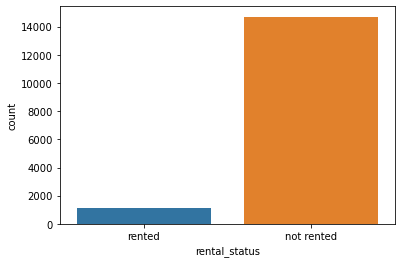

In [112]:
import seaborn as sns
%matplotlib inline
sns.countplot(x=data.rental_status)

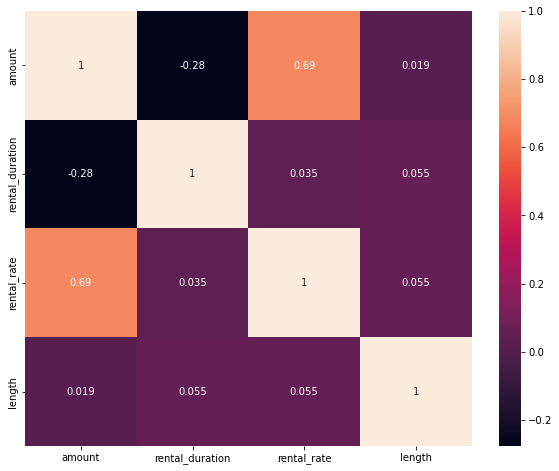

In [113]:
import matplotlib.pyplot as plt
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

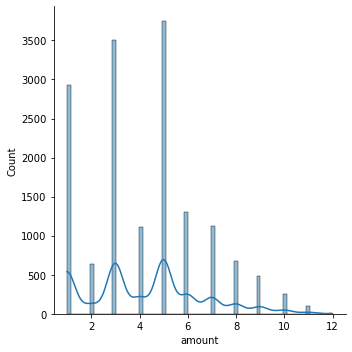

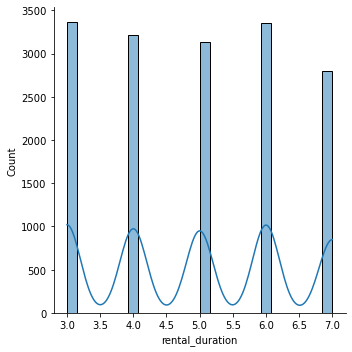

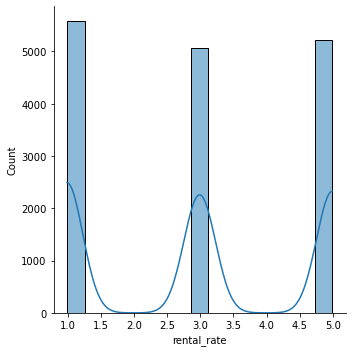

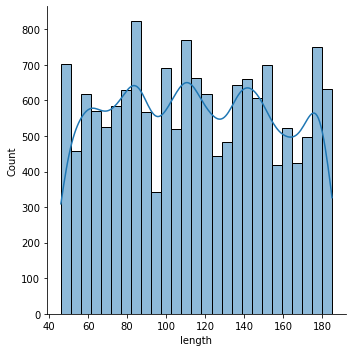

In [114]:

numerical =data.select_dtypes(include = np.number)
for col in numerical.columns:
    sns.displot(numerical[col],kde = True)
    plt.show()

In [115]:
# Need to X-y-split AND train-test-split BEFORE I apply transformations, 
# then train transformation on training set only
y = data['rental_status']
X = data.drop('rental_status', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [116]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized, columns = X_train_num.columns)

In [117]:
X_train_norm.head()

,amount,rental_duration,rental_rate,length
0,0.181818,0.00,0.5,0.007194
1,0.363636,1.00,1.0,0.244604
2,0.272727,1.00,0.5,0.122302
3,0.181818,0.25,0.5,0.151079
4,0.454545,0.00,0.0,0.194245


In [118]:
X_train_categorical = X_train.select_dtypes(include = object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns= X_train_categorical.columns,
                             drop_first=True)
X_train_cat.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
7563,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9589,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6140,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6911,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2596,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [119]:
# build X_train and y_train
# remember: y = data['status'], y_train selected in train_test_split
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [120]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [121]:
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [122]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [123]:
# for categoricals
X_test_categorical = X_test.select_dtypes(include = object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=X_test_categorical.columns,
                            drop_first=True)
# verify that dummies columns are in the same order and that the same column was dropped
display(list(zip(list(X_train_cat.columns),list(X_test_cat.columns))))
# not needed if you treat each dataframe with one_hot_encoder and save the encode (and the column names)

# X_test_cat.head()

[('rating_NC-17', 'rating_NC-17'),
 ('rating_PG', 'rating_PG'),
 ('rating_PG-13', 'rating_PG-13'),
 ('rating_R', 'rating_R'),
 ('category_Animation', 'category_Animation'),
 ('category_Children', 'category_Children'),
 ('category_Classics', 'category_Classics'),
 ('category_Comedy', 'category_Comedy'),
 ('category_Documentary', 'category_Documentary'),
 ('category_Drama', 'category_Drama'),
 ('category_Family', 'category_Family'),
 ('category_Foreign', 'category_Foreign'),
 ('category_Games', 'category_Games'),
 ('category_Horror', 'category_Horror'),
 ('category_Music', 'category_Music'),
 ('category_New', 'category_New'),
 ('category_Sci-Fi', 'category_Sci-Fi'),
 ('category_Sports', 'category_Sports'),
 ('category_Travel', 'category_Travel')]

In [124]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [125]:
# Now we can make predictions on the test set:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.9271982351087299

In [126]:
print(y_test.value_counts())

not rented    2942
rented         231
Name: rental_status, dtype: int64


In [127]:
pd.Series(predictions).value_counts()
# This shows that the disparity in the numbers are amplified by the model

not rented    3173
dtype: int64

In [128]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[2942,    0],
       [ 231,    0]])

In [129]:
# predicted | A | B | C | D |
# --------------------------
# actual  A | + |  |   |   |
# --------------------------
#         B |   | + |   |   |
# --------------------------
#         C |   |   | + |   |
# --------------------------
#         D |   |   |   | + |

In [130]:
# bonus: KNN classifier: look at nearest neighbours and use the majority to determine class
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.9268830759533564

In [131]:
confusion_matrix(y_test, predictions_clf)

array([[2941,    1],
       [ 231,    0]])

In [132]:
pd.Series(y_test).value_counts()

not rented    2942
rented         231
Name: rental_status, dtype: int64

In [133]:
pd.Series(predictions_clf).value_counts()

not rented    3172
rented           1
dtype: int64